In [2]:
!pip freeze | grep scikit-learn

scikit-learn==1.4.1.post1
scikit-learn-intelex==2024.2.0


In [3]:
!python -V

Python 3.11.7


In [24]:
import os
import boto3
import pickle
import pandas as pd

In [5]:
with open('model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

/home/renan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DictVectorizer from version 1.5.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/renan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.5.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [7]:
df = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet')

In [8]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)

In [9]:
X_val

<3316216x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6632424 stored elements in Compressed Sparse Row format>

In [10]:
y_pred

array([16.24590642, 26.1347962 , 11.88426424, ..., 11.59533603,
       13.11317847, 12.89999218])

# Q1
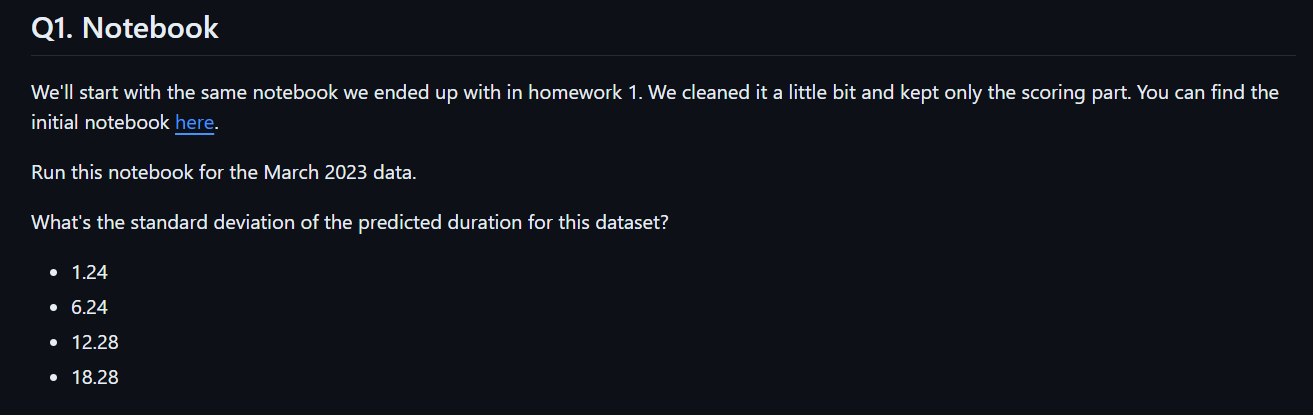

## Answer

In [11]:
round(pd.Series(y_pred).std(), 2)

6.25

# Q2
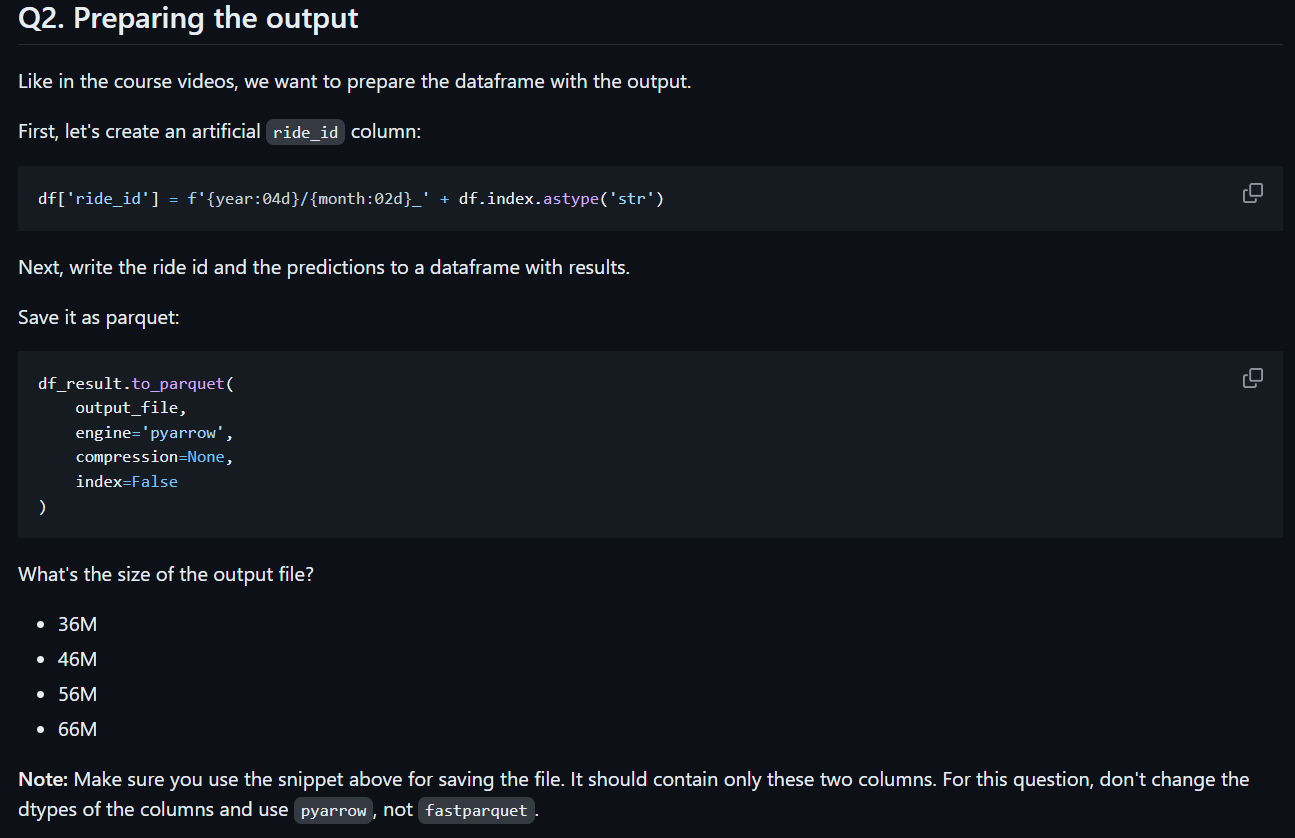

In [15]:
year = 2023
month = 3
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')

In [17]:
df['y_pred'] = y_pred

In [19]:
output_file = 'df_result.parquet'
df_result = df[['ride_id', 'y_pred']]

df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)

## Answer

In [27]:
os.stat(output_file).st_size / (1024 * 1024)

65.46183013916016

In [22]:
!ls -lah df_result.parquet

-rw-r--r-- 1 renan renan 66M Jun 17 15:45 df_result.parquet


# Q3
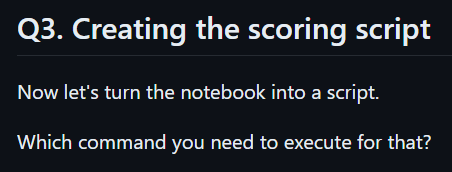

## Answer

In [51]:
!jupyter nbconvert --to script --no-prompt homework.ipynb \
--TemplateExporter.exclude_markdown=True \
--TemplateExporter.exclude_output_prompt=True \
--TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook homework.ipynb to script
[NbConvertApp] Writing 1551 bytes to homework.py


# Q4
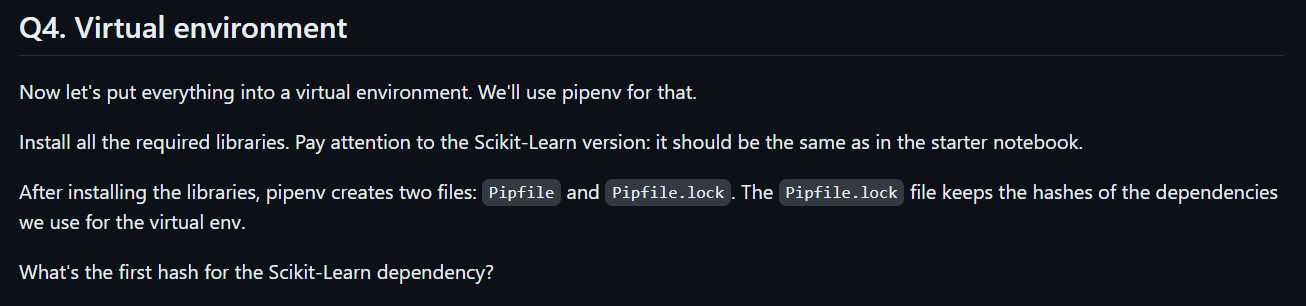

```bash
pyenv install 3.10.13
pipenv install --python 3.10.13 scikit-learn==1.5.0 pandas[parquet] flask gunicorn
```

## Answer

In [39]:
with open('Pipfile.lock', 'r') as f:
    pipfile = f.read()
pipfile = eval(pipfile.replace('true', 'True'))

In [49]:
pipfile['default']['scikit-learn']['hashes'][0]

'sha256:057b991ac64b3e75c9c04b5f9395eaf19a6179244c089afdebaad98264bff37c'

# Q5
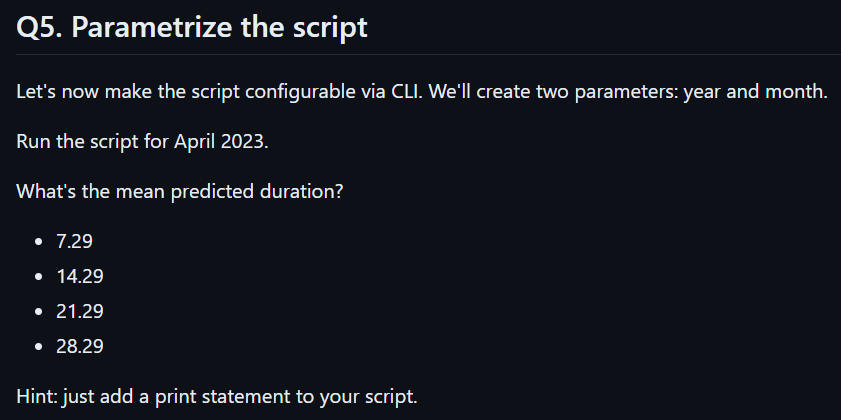

In [ ]:
!python predict_script.py 2023 04

## Answer

In [59]:
round(pd.read_parquet('df_result_2023_04.parquet')['y_pred'].mean(), 2)

14.29

# Q6
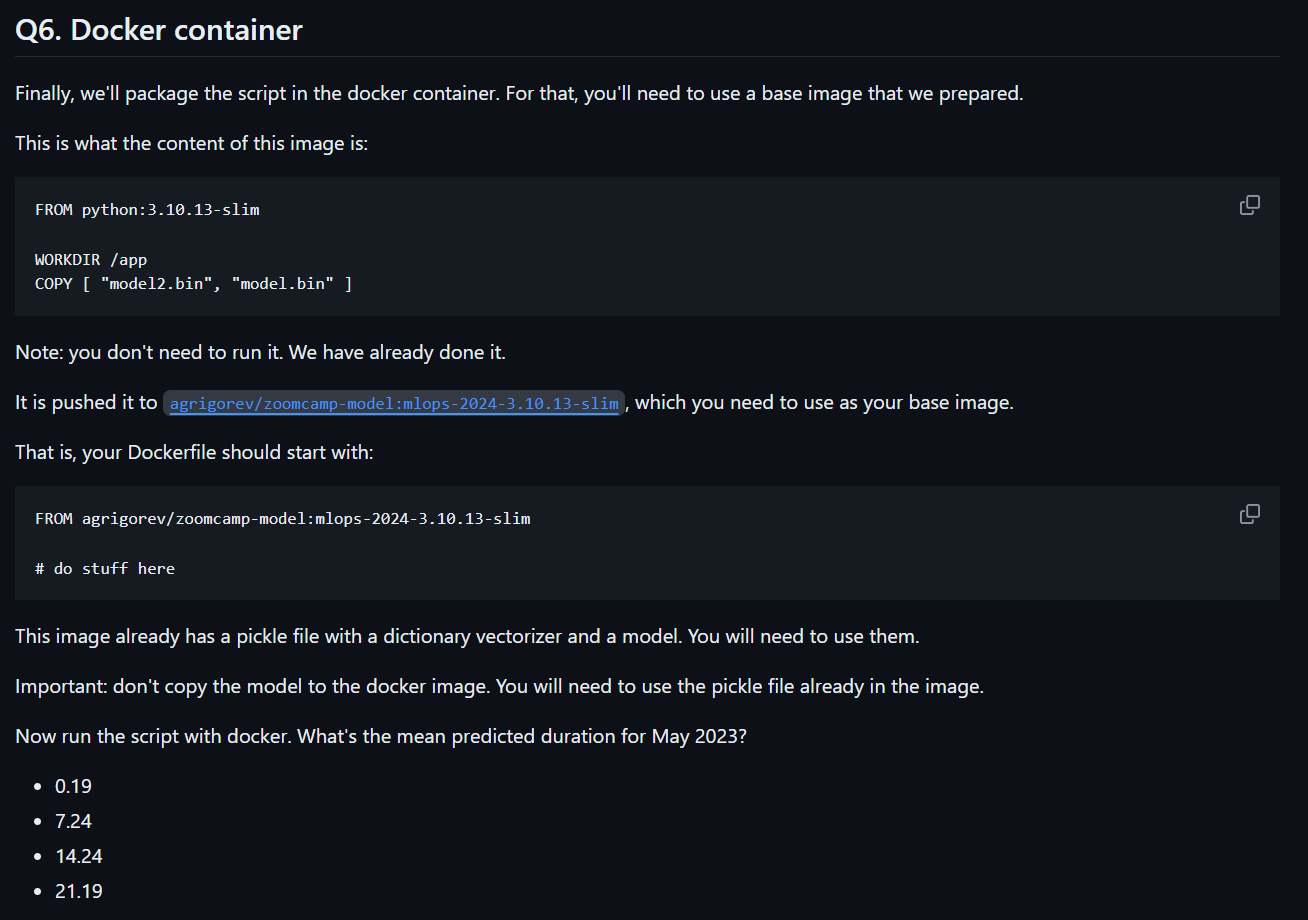

In [67]:
!docker build -t ride-duration-prediction-service:v1 .

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 299B                                       0.0s
 => [internal] load metadata for docker.io/agrigorev/zoomcamp-model:mlops  0.2s
[+] Building 0.3s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 299B                                       0.0s
 => [internal] load metadata for docker.io/agrigorev/zoomcamp-model:mlops  0.3s
[+] Building 0.5s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 299B                                       0.0s
 => [internal] load metadata for docker.

## Answer

In [70]:
!docker run -it --rm --name my-running-prediction ride-duration-prediction-service:v1 python predict_script.py 2023 05

0.19


# B1
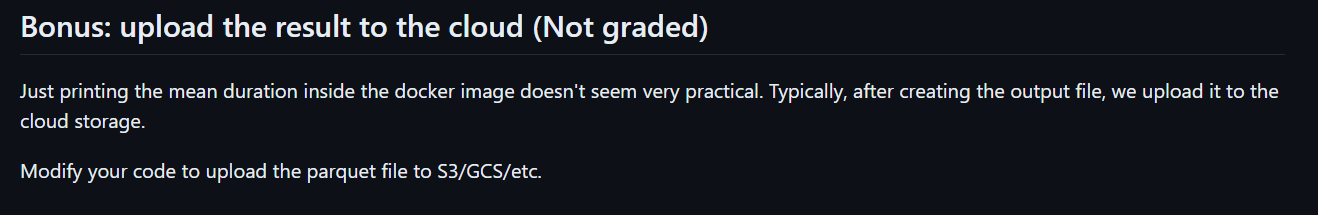

In [89]:
!aws s3 ls mlops-zoomcamp-renan-9999

In [90]:
filename = 'df_result_2023_05.parquet'
boto3.client('s3').upload_file(filename, 'mlops-zoomcamp-renan-9999', filename)

In [91]:
!aws s3 ls mlops-zoomcamp-renan-9999

2024-06-18 00:29:41   70390369 df_result_2023_05.parquet


In [92]:
!pipenv install boto3

Installing boto3...
Resolving boto3...
✔ Installation Succeeded
⠋ Installing boto3...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
Installing dependencies from Pipfile.lock (db66a0)...


In [93]:
!docker build -t ride-duration-prediction-service:v1 .

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 299B                                       0.0s
 => [internal] load metadata for docker.io/agrigorev/zoomcamp-model:mlops  0.2s
[+] Building 0.3s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 299B                                       0.0s
 => [internal] load metadata for docker.io/agrigorev/zoomcamp-model:mlops  0.3s
[+] Building 0.5s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 299B                                       0.0s
 => [internal] load metadata for docker.

In [94]:
!docker run -v ~/.aws:/root/.aws:ro -it --rm --name my-running-prediction ride-duration-prediction-service:v1 python predict_script.py 2023 06

0.19


In [95]:
!aws s3 ls mlops-zoomcamp-renan-9999

2024-06-18 00:29:41   70390369 df_result_2023_05.parquet
2024-06-18 00:30:12   66387328 df_result_2023_06.parquet


# B2
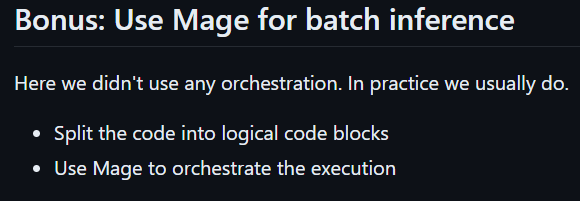

In [96]:
!aws s3 ls mlops-zoomcamp-renan-9999

2024-06-18 00:29:41   70390369 df_result_2023_05.parquet
2024-06-18 00:30:12   66387328 df_result_2023_06.parquet


```bash
docker run  -it -p 6789:6789 -v $(pwd):/home/src mageai/mageai /app/run_app.sh mage start ride-duration-prediction-service
```

In [98]:
!aws s3 ls mlops-zoomcamp-renan-9999

2024-06-18 00:29:41   70390369 df_result_2023_05.parquet
2024-06-18 00:30:12   66387328 df_result_2023_06.parquet
2024-06-18 02:50:08   23137288 df_result_2023_07.parquet
